# Pythonで学ぶ画像認識　第6章 画像キャプショニング
## 第6.5節 Transformerによる画像キャプショニングを実装してみよう

### ライブラリの準備

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.4 MB/s eta 0:00:00


###モジュールのインポートとGoogleドライブのマウント

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
from tqdm import tqdm
import pickle
import random
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import skimage.transform
from collections import deque

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dataset

from timm.scheduler import CosineLRScheduler

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/6_img_captioning/6_5_transformer_captioning')

import util
import model

Mounted at /content/drive


### 位置エンコーディングの実装

In [3]:
class PositionalEncoding(nn.Module):
    '''
    位置エンコーディング Positional encoding）
    dim_embedding: 埋込み次元
    dropout      : Dropout確率
    max_len      : 入力の最大系列長
    temperature  : 温度定数
    '''
    def __init__(self, dim_embedding: int, dropout: float=0.1,
                 max_len: int=5000, temperature=10000):
        super().__init__()

        assert dim_embedding % 2 == 0
        
        self.dropout = nn.Dropout(p=dropout)

        dim_t = torch.arange(0, dim_embedding, 2)
        dim_t = dim_t / dim_embedding
        dim_t = temperature ** dim_t

        x_encoding = torch.arange(max_len).unsqueeze(1)
        x_encoding = x_encoding / dim_t
        
        # 位置情報を保持するテンソル（positional encoding）
        pe = torch.zeros(max_len, dim_embedding)
        pe[:, ::2] = x_encoding.sin()
        pe[:, 1::2] = x_encoding.cos()

        # PEをメモリに保存
        self.register_buffer('pe', pe)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        x = x + self.pe[:seq]
        x = self.dropout(x)
        
        return x

### Transformerデコーダの実装

In [4]:
class TransformerDecoderLayer(nn.Module):
    '''
    Transformerデコーダ層
    dim_hidden     : 特徴量次元
    num_heads      : アテンションヘッドの数
    dim_feedforward: FNNの中間特徴量次元
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_hidden: int, num_heads: int, 
                 dim_feedforward: int=2048, dropout: int=0.1):
        super().__init__()

        # 単語ベクトルに対するマルチヘッドセルフアテンション
        self.self_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim_hidden)
        self.dropout1 = nn.Dropout(dropout)
        
        # エンコーダとデコーダ中間出力に対するマルチヘッドアテンション
        self.cross_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim_hidden)
        self.dropout2 = nn.Dropout(dropout)
        
        # FNNブロック
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(dim_hidden)

    '''
    Transformerデコーダ層の順伝播
    tgt     : デコーダへの入力系列,
              [バッチサイズ, 系列長, 埋め込み次元]
    memory  : エンコーダ層の特徴量, [バッチサイズ, 1, 埋め込み次元]
    tgt_mask: 入力系列のマスク, [系列長, 系列長]
    '''
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor=None):

        # デコーダ入力に対するマスク付きマルチヘッドセルフアテンション
        tgt2 = self.self_attention(
            query=tgt, key=tgt, value=tgt, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout1(tgt2)  # 残差接続
        tgt = self.norm1(tgt)            # レイヤ正規化
        
        # エンコーダとデコーダ中間出力に対するマルチヘッドアテンション
        tgt2 = self.cross_attention(
            query=tgt, key=memory, value=memory)[0]
        tgt = tgt + self.dropout2(tgt2)  # 残差接続
        tgt = self.norm2(tgt)            # レイヤ正規化

        # FNNブロック
        tgt2 = self.fnn(tgt)
        tgt = tgt + self.dropout3(tgt2)  # 残差接続
        tgt = self.norm3(tgt)            # レイヤ正規化

        return tgt

### CaptioningTransformerの実装

In [5]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, vocab_size: int,
                 null_index: int, dropout: float=0.5):
        super().__init__()

        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=null_index)
        
        self.positional_encoding = PositionalEncoding(dim_embedding)
        
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(
                dim_embedding, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        
        self.linear = nn.Linear(dim_embedding, vocab_size)

        self._reset_parameters()

    '''
    パラメータの初期化関数
    '''
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, nn.LayerNorm):
                nn.init.zeros_(module.bias)
                nn.init.ones_(module.weight)

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, features: torch.Tensor,
                captions: torch.Tensor):
        seq = captions.shape[1]

        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)

        # 位置エンコード
        embeddings = self.positional_encoding(embeddings) 

        features = features.unsqueeze(1)

        # 未来のキャプションを参照しないようにマスク行列を生成
        tgt_mask = torch.tril(features.new_ones((seq, seq)))
        tgt_mask = tgt_mask == 0

        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            embeddings = layer(embeddings, features, tgt_mask)

        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)

        return preds

    '''
    CaptioningTransformerのサンプリング処理
    features  : 画像特徴ベクトル [バッチサイズ, 埋め込み次元]
    word_to_id: 単語->単語ID辞書
    max_length: 最大キャプション長
    '''
    @torch.no_grad()
    def sample(self, features: torch.Tensor, word_to_id: list,
               max_length: int=30):
        bs = features.shape[0]

        # NULLトークンで出力キャプションを初期化
        captions = features.new_full(
            (bs, 1), word_to_id['<start>'], dtype=torch.int64)

        for _ in range(max_length):
            # トークン予測
            preds = self.forward(features, captions)
            preds = preds[:, -1]
            preds = preds.softmax(dim=1)
            words = preds.argmax(dim=1, keepdim=True)

            captions = torch.cat((captions, words), dim=1)
                
        return captions

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、グローバル変数の設定
    '''  
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 300   # 埋め込み層の次元
        self.dim_feedforward = 128 # FNNの中間特徴量次元
        self.num_heads = 4         # マルチヘッドアテンションのヘッド数
        self.num_layers = 8        # Transformerデコーダ層の層数
        self.lr = 0.001            # 学習率
        self.dropout = 0.3         # dropout確率
        self.batch_size = 30       # ミニバッチ数
        self.num_epochs = 100       # エポック数
        
        # パスの設定
        self.img_directory = 'val2014'
        self.anno_file = 'drive/MyDrive/python_image_recognition/data/coco2014/captions_val2014.json'
        self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/word_to_id.pkl'
        self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model'

        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.3

        # データローダーに使うCPUプロセスの数
        self.num_workers = 4

        # 学習に使うデバイス
        self.device = 'cuda'

        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

### 学習率スケジューラ

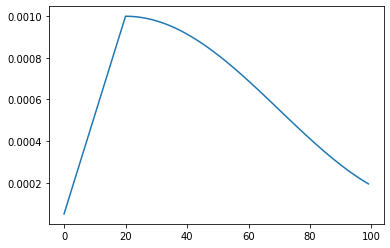

In [7]:
linear = torch.nn.Linear(1, 1)
optimizer = torch.optim.AdamW(linear.parameters())
scheduler = CosineLRScheduler(
    optimizer, t_initial=100, lr_min=1e-4, warmup_t=20,
    warmup_lr_init=5e-5, warmup_prefix=True)

lrs = []
for i in range(100):
    lrs.append(scheduler.get_epoch_values(i))
plt.plot(lrs)
plt.show()

### 学習を行う関数

In [8]:
def train():
    config = ConfigTrain()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)

    # 辞書サイズを保存
    vocab_size = len(word_to_id)
        
    # モデル出力用のディレクトリを作成
    os.makedirs(config.save_directory, exist_ok=True)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])

    # COCOデータロードの定義
    train_dataset = dataset.CocoCaptions(root=config.img_directory, 
                                         annFile=config.anno_file, 
                                         transform=transforms)
    
    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    collate_func_lambda = lambda x: util.collate_func(x, word_to_id)
    train_loader = torch.utils.data.DataLoader(
                        train_dataset, 
                        batch_size=config.batch_size, 
                        num_workers=config.num_workers, 
                        sampler=train_sampler,
                        collate_fn=collate_func_lambda)
    val_loader = torch.utils.data.DataLoader(
                        train_dataset, 
                        batch_size=config.batch_size, 
                        num_workers=config.num_workers, 
                        sampler=val_set,
                        collate_fn=collate_func_lambda)

    # モデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'], config.dropout)
    encoder.to(config.device)
    decoder.to(config.device)
    
    # 損失関数の定義
    loss_func = lambda x, y: F.cross_entropy(
        x, y, ignore_index=word_to_id.get('<null>', None))
    
    # 最適化手法の定義
    params = list(decoder.parameters()) + \
    list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=config.lr)

    # WarmupとCosine Decayを行うスケジューラを利用
    scheduler = CosineLRScheduler(
        optimizer, t_initial=config.num_epochs, lr_min=1e-4,
        warmup_t=20, warmup_lr_init=5e-5, warmup_prefix=True)
    
    # 学習経過の書き込み
    now = datetime.datetime.now()
    train_loss_file = '{}/6-5_train_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
    val_loss_file = '{}/6-5_val_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

    # 学習
    val_loss_best = float('inf')
    for epoch in range(config.num_epochs):
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 学習モードに設定
            encoder.train()
            decoder.train()

            train_losses = deque()
            for imgs, captions, _ in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)

                optimizer.zero_grad()

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                captions_in = captions[:, :-1]
                outputs = decoder(features, captions_in)

                # ロスの計算
                # <start>の予測は行わないため除外
                targets = captions[:, 1:] 
                # 単語軸が第1軸である必要があるため、転置
                outputs = outputs.transpose(1, 2)
                loss = loss_func(outputs, targets)

                # 誤差逆伝播
                loss.backward()
                
                optimizer.step()

                # 学習時の損失をログに書き込み
                train_losses.append(loss.item())
                if len(train_losses) > config.moving_avg:
                    train_losses.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(train_losses).mean().item()})
                with open(train_loss_file, 'a') as f:
                    print(f'{epoch}, {loss.item()}', file=f)

        # 学習率を表示
        print(f'学習率: {scheduler.get_epoch_values(epoch)}')
        
        # 検証
        with tqdm(val_loader) as pbar:
            pbar.set_description(f'[検証]')

            # 評価モード
            encoder.eval()
            decoder.eval()

            val_losses = []
            for imgs, captions, _ in pbar:

                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                captions_in = captions[:, :-1]
                outputs = decoder(features, captions_in)

                # ロスの計算
                # <start>の予測は行わないため除外
                targets = captions[:, 1:] 
                # 単語軸が第1軸である必要があるため、転置
                outputs = outputs.transpose(1, 2)
                loss = loss_func(outputs, targets)
                val_losses.append(loss.item())

                # Validation Lossをログに書き込み
                with open(val_loss_file, 'a') as f:
                    print(f'{epoch}, {loss.item()}', file=f)

        # Loss 表示
        val_loss = np.mean(val_losses)
        print(f'Validation loss: {val_loss}')

        # より良い検証結果が得られた場合、モデルを保存
        if val_loss < val_loss_best:
            val_loss_best = val_loss

            # エンコーダモデルを保存
            torch.save(
                encoder.state_dict(),
                f'{config.save_directory}/6-5_encoder_best.pth')

            # デコーダモデルを保存
            torch.save(
                decoder.state_dict(),
                f'{config.save_directory}/6-5_decoder_best.pth')

###学習データの解凍

In [ ]:
!unzip drive/MyDrive/python_image_recognition/data/coco2014/val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

###学習の実行

In [ ]:
train()

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

[エポック 1]: 100%|██████████| 946/946 [01:47<00:00,  8.83it/s, loss=4.92]


学習率: [5e-05]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 4.84059774288403


[エポック 2]: 100%|██████████| 946/946 [01:40<00:00,  9.42it/s, loss=4.21]


学習率: [9.750000000000001e-05]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 4.146674259542832


[エポック 3]: 100%|██████████| 946/946 [01:40<00:00,  9.42it/s, loss=3.9]


学習率: [0.000145]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.42it/s]


Validation loss: 3.8670239918337668


[エポック 4]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=3.72]


学習率: [0.0001925]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.66it/s]


Validation loss: 3.6604126210283177


[エポック 5]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=3.59]


学習率: [0.00024]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.56it/s]


Validation loss: 3.531042921132055


[エポック 6]: 100%|██████████| 946/946 [01:39<00:00,  9.46it/s, loss=3.49]


学習率: [0.00028750000000000005]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.61it/s]


Validation loss: 3.430314238435529


[エポック 7]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=3.43]


学習率: [0.000335]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.27it/s]


Validation loss: 3.374250342693235


[エポック 8]: 100%|██████████| 946/946 [01:41<00:00,  9.34it/s, loss=3.31]


学習率: [0.00038250000000000003]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.50it/s]


Validation loss: 3.2989458579735214


[エポック 9]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=3.28]


学習率: [0.00043000000000000004]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.52it/s]


Validation loss: 3.250299991645249


[エポック 10]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=3.24]


学習率: [0.00047750000000000006]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 3.1883297453960173


[エポック 11]: 100%|██████████| 946/946 [01:40<00:00,  9.41it/s, loss=3.2]


学習率: [0.0005250000000000001]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.48it/s]


Validation loss: 3.1423375406875986


[エポック 12]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=3.16]


学習率: [0.0005725000000000001]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.49it/s]


Validation loss: 3.1291379012497775


[エポック 13]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=3.12]


学習率: [0.00062]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 3.073020840513295


[エポック 14]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=3.05]


学習率: [0.0006675]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 3.052828340694822


[エポック 15]: 100%|██████████| 946/946 [01:40<00:00,  9.40it/s, loss=3.01]


学習率: [0.000715]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 3.0324616355849017


[エポック 16]: 100%|██████████| 946/946 [01:41<00:00,  9.30it/s, loss=3.01]


学習率: [0.0007625]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 3.007656032228705


[エポック 17]: 100%|██████████| 946/946 [01:41<00:00,  9.31it/s, loss=2.99]


学習率: [0.0008100000000000001]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.9895070650307414


[エポック 18]: 100%|██████████| 946/946 [01:41<00:00,  9.37it/s, loss=2.98]


学習率: [0.0008575000000000001]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.69it/s]


Validation loss: 2.9515124870638543


[エポック 19]: 100%|██████████| 946/946 [01:40<00:00,  9.41it/s, loss=2.91]


学習率: [0.0009050000000000001]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.62it/s]


Validation loss: 2.951121375478547


[エポック 20]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.97]


学習率: [0.0009525000000000001]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.9300763107872947


[エポック 21]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.94]


学習率: [0.001]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.56it/s]


Validation loss: 2.8950868924263076


[エポック 22]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.89]


学習率: [0.0009997779521645793]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.66it/s]


Validation loss: 2.8998113899982623


[エポック 23]: 100%|██████████| 946/946 [01:40<00:00,  9.43it/s, loss=2.88]


学習率: [0.0009991120277927223]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.67it/s]


Validation loss: 2.874544185370647


[エポック 24]: 100%|██████████| 946/946 [01:41<00:00,  9.37it/s, loss=2.85]


学習率: [0.000998002884071386]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 2.8604979262563397


[エポック 25]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.83]


学習率: [0.000996451615591515]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 2.830371042190514


[エポック 26]: 100%|██████████| 946/946 [01:40<00:00,  9.40it/s, loss=2.83]


学習率: [0.000994459753267812]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.51it/s]


Validation loss: 2.830203398107895


[エポック 27]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.79]


学習率: [0.00099202926282791]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.71it/s]


Validation loss: 2.836198890737712


[エポック 28]: 100%|██████████| 946/946 [01:39<00:00,  9.47it/s, loss=2.79]


学習率: [0.0009891625428724363]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 2.82398992982404


[エポック 29]: 100%|██████████| 946/946 [01:40<00:00,  9.41it/s, loss=2.78]


学習率: [0.000985862422507884]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.65it/s]


Validation loss: 2.8387538541126722


[エポック 30]: 100%|██████████| 946/946 [01:39<00:00,  9.47it/s, loss=2.78]


学習率: [0.0009821321585546244]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 2.8042099963268035


[エポック 31]: 100%|██████████| 946/946 [01:41<00:00,  9.33it/s, loss=2.74]


学習率: [0.0009779754323328191]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.49it/s]


Validation loss: 2.8067935382204103


[エポック 32]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.73]


学習率: [0.0009733963460294015]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 2.7882725464299396


[エポック 33]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.75]


学習率: [0.0009683994186497131]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.50it/s]


Validation loss: 2.7762920016725663


[エポック 34]: 100%|██████████| 946/946 [01:41<00:00,  9.28it/s, loss=2.71]


学習率: [0.0009629895815577914]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.7563521521432057


[エポック 35]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.7]


学習率: [0.0009571721736097088]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.51it/s]


Validation loss: 2.744851866085541


[エポック 36]: 100%|██████████| 946/946 [01:41<00:00,  9.34it/s, loss=2.72]


学習率: [0.0009509529358847655]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.71it/s]


Validation loss: 2.7486535234404315


[エポック 37]: 100%|██████████| 946/946 [01:40<00:00,  9.44it/s, loss=2.69]


学習率: [0.0009443380060197386]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.7426672199089537


[エポック 38]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.68]


学習率: [0.0009373339121517746]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.65it/s]


Validation loss: 2.7460246585272805


[エポック 39]: 100%|██████████| 946/946 [01:40<00:00,  9.42it/s, loss=2.65]


学習率: [0.0009299475664759069]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 2.725691962418298


[エポック 40]: 100%|██████████| 946/946 [01:41<00:00,  9.29it/s, loss=2.66]


学習率: [0.0009221862584235528]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.62it/s]


Validation loss: 2.736915438046009


[エポック 41]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.62]


学習率: [0.0009140576474687263]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.66it/s]


Validation loss: 2.731604487731539


[エポック 42]: 100%|██████████| 946/946 [01:40<00:00,  9.42it/s, loss=2.61]


学習率: [0.0009055697555690606]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.7363082117635043


[エポック 43]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.65]


学習率: [0.0008967309592491052]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.724107476290811


[エポック 44]: 100%|██████████| 946/946 [01:40<00:00,  9.44it/s, loss=2.67]


学習率: [0.0008875499813337069]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.69it/s]


Validation loss: 2.70931102195984


[エポック 45]: 100%|██████████| 946/946 [01:41<00:00,  9.29it/s, loss=2.61]


学習率: [0.0008780358823396353]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 2.70642966648628


[エポック 46]: 100%|██████████| 946/946 [01:41<00:00,  9.29it/s, loss=2.58]


学習率: [0.0008681980515339464]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.695664966047691


[エポック 47]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.6]


学習率: [0.0008580461976679099]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.70it/s]


Validation loss: 2.696879627082148


[エポック 48]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.6]


学習率: [0.0008475903393956434]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.6946070106158704


[エポック 49]: 100%|██████████| 946/946 [01:42<00:00,  9.27it/s, loss=2.56]


学習率: [0.0008368407953869105]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.47it/s]


Validation loss: 2.6997777534823113


[エポック 50]: 100%|██████████| 946/946 [01:40<00:00,  9.42it/s, loss=2.56]


学習率: [0.0008258081741438395]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 2.677224889177407


[エポック 51]: 100%|██████████| 946/946 [01:41<00:00,  9.31it/s, loss=2.59]


学習率: [0.0008145033635316131]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.61it/s]


Validation loss: 2.670309729764027


[エポック 52]: 100%|██████████| 946/946 [01:41<00:00,  9.28it/s, loss=2.59]


学習率: [0.0008029375200334589]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 2.676775837473094


[エポック 53]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.6]


学習率: [0.0007911220577405485]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 2.6797343427911766


[エポック 54]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=2.55]


学習率: [0.0007790686370876671]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.6643110064450157


[エポック 55]: 100%|██████████| 946/946 [01:41<00:00,  9.34it/s, loss=2.55]


学習率: [0.0007667891533457719]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.61it/s]


Validation loss: 2.674763227918465


[エポック 56]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.53]


学習率: [0.000754295724882796]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.664121341235532


[エポック 57]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.55]


学習率: [0.0007416006812042827]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.51it/s]


Validation loss: 2.63733495338797


[エポック 58]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.56]


学習率: [0.0007287165507856513]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.658488342914675


[エポック 59]: 100%|██████████| 946/946 [01:40<00:00,  9.40it/s, loss=2.52]


学習率: [0.0007156560487081052]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.6542875452581884


[エポック 60]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.53]


学習率: [0.0007024320641103813]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.67it/s]


Validation loss: 2.6552270239797133


[エポック 61]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.52]


学習率: [0.0006890576474687264]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.56it/s]


Validation loss: 2.6507312100509117


[エポック 62]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=2.5]


学習率: [0.0006755459977176532]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 2.6413685259560644


[エポック 63]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.52]


学習率: [0.0006619104492241846]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.6455589615065476


[エポック 64]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.49]


学習率: [0.0006481644586284443]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.62it/s]


Validation loss: 2.646952842256706


[エポック 65]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.47]


学習率: [0.0006343215915635762]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.51it/s]


Validation loss: 2.6351213079367954


[エポック 66]: 100%|██████████| 946/946 [01:42<00:00,  9.27it/s, loss=2.5]


学習率: [0.000620395509268104]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.52it/s]


Validation loss: 2.6378833457754163


[エポック 67]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.46]


学習率: [0.000606399955103937]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.631355842933279


[エポック 68]: 100%|██████████| 946/946 [01:41<00:00,  9.29it/s, loss=2.49]


学習率: [0.0005923487409933315]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.6462476024486747


[エポック 69]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.47]


学習率: [0.0005782557337881911]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.6267604863115133


[エポック 70]: 100%|██████████| 946/946 [01:41<00:00,  9.33it/s, loss=2.48]


学習率: [0.0005641348415851578]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.41it/s]


Validation loss: 2.610043402375846


[エポック 71]: 100%|██████████| 946/946 [01:42<00:00,  9.26it/s, loss=2.46]


学習率: [0.00055]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.47it/s]


Validation loss: 2.622200711313727


[エポック 72]: 100%|██████████| 946/946 [01:41<00:00,  9.33it/s, loss=2.45]


学習率: [0.0005358651584148423]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.46it/s]


Validation loss: 2.6119020660522536


[エポック 73]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.46]


学習率: [0.000521744266211809]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.55it/s]


Validation loss: 2.6232375255946456


[エポック 74]: 100%|██████████| 946/946 [01:41<00:00,  9.33it/s, loss=2.45]


学習率: [0.0005076512590066686]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.53it/s]


Validation loss: 2.619154306761737


[エポック 75]: 100%|██████████| 946/946 [01:40<00:00,  9.39it/s, loss=2.47]


学習率: [0.0004936000448960632]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.608835986095109


[エポック 76]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.44]


学習率: [0.0004796044907318961]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.66it/s]


Validation loss: 2.6173007658549716


[エポック 77]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.45]


学習率: [0.0004656784084364239]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.68it/s]


Validation loss: 2.596446507376403


[エポック 78]: 100%|██████████| 946/946 [01:41<00:00,  9.33it/s, loss=2.4]


学習率: [0.00045183554137155597]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.53it/s]


Validation loss: 2.6118661168173616


[エポック 79]: 100%|██████████| 946/946 [01:41<00:00,  9.31it/s, loss=2.42]


学習率: [0.0004380895507758153]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 2.607563945460202


[エポック 80]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.45]


学習率: [0.00042445400228234684]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.6050269727049202


[エポック 81]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.4]


学習率: [0.0004109423525312738]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 2.611088142606425


[エポック 82]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.41]


学習率: [0.0003975679358896189]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.61it/s]


Validation loss: 2.6078402834572816


[エポック 83]: 100%|██████████| 946/946 [01:41<00:00,  9.31it/s, loss=2.39]


学習率: [0.000384343951291895]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.599817156204449


[エポック 84]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=2.41]


学習率: [0.00037128344921434864]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.70it/s]


Validation loss: 2.5961910051665282


[エポック 85]: 100%|██████████| 946/946 [01:42<00:00,  9.25it/s, loss=2.39]


学習率: [0.0003583993187957173]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.49it/s]


Validation loss: 2.6143125501172295


[エポック 86]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.38]


学習率: [0.00034570427511720393]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.62it/s]


Validation loss: 2.6110345606733425


[エポック 87]: 100%|██████████| 946/946 [01:41<00:00,  9.29it/s, loss=2.39]


学習率: [0.0003332108466542281]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.596382069763879


[エポック 88]: 100%|██████████| 946/946 [01:41<00:00,  9.32it/s, loss=2.37]


学習率: [0.0003209313629123329]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.64it/s]


Validation loss: 2.590174451837399


[エポック 89]: 100%|██████████| 946/946 [01:41<00:00,  9.31it/s, loss=2.39]


学習率: [0.0003088779422594514]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 2.5963298845760927


[エポック 90]: 100%|██████████| 946/946 [01:41<00:00,  9.36it/s, loss=2.43]


学習率: [0.0002970624799665412]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.60it/s]


Validation loss: 2.5944606018771093


[エポック 91]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.39]


学習率: [0.00028549663646838715]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.63it/s]


Validation loss: 2.585570111063314


[エポック 92]: 100%|██████████| 946/946 [01:42<00:00,  9.27it/s, loss=2.37]


学習率: [0.00027419182585616055]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.50it/s]


Validation loss: 2.5890703195421567


[エポック 93]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.35]


学習率: [0.0002631592046130896]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.49it/s]


Validation loss: 2.600396225311486


[エポック 94]: 100%|██████████| 946/946 [01:41<00:00,  9.34it/s, loss=2.36]


学習率: [0.00025240966060435674]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.57it/s]


Validation loss: 2.5818364050588


[エポック 95]: 100%|██████████| 946/946 [01:40<00:00,  9.37it/s, loss=2.35]


学習率: [0.00024195380233209008]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.71it/s]


Validation loss: 2.590817571273578


[エポック 96]: 100%|██████████| 946/946 [01:40<00:00,  9.40it/s, loss=2.37]


学習率: [0.00023180194846605365]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.58it/s]


Validation loss: 2.573985600119154


[エポック 97]: 100%|██████████| 946/946 [01:41<00:00,  9.28it/s, loss=2.35]


学習率: [0.0002219641176603649]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 2.579034700769509


[エポック 98]: 100%|██████████| 946/946 [01:40<00:00,  9.38it/s, loss=2.35]


学習率: [0.0002124500186662932]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.59it/s]


Validation loss: 2.580053774594086


[エポック 99]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.33]


学習率: [0.00020326904075089488]


[検証]: 100%|██████████| 406/406 [00:29<00:00, 13.54it/s]


Validation loss: 2.5871956662591455


[エポック 100]: 100%|██████████| 946/946 [01:41<00:00,  9.35it/s, loss=2.37]


学習率: [0.00019443024443093932]


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.47it/s]


Validation loss: 2.5762693153813556


###デモにおけるハイパーパラメータやオプションの設定

In [9]:
class ConfigDemo(object):
    '''
    ハイパーパラメータ、グローバル変数の設定
    '''  
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 300   # 埋め込み層の次元
        self.dim_feedforward = 128 # FNNの中間特徴量次元
        self.num_heads = 4         # マルチヘッドアテンションのヘッド数
        self.num_layers = 8        # Transformerデコーダ層の層数
        
        # パスの設定
        # 画像キャプショニング推論
        self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/word_to_id.pkl'
        self.id_to_word_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/id_to_word.pkl'
        self.img_dirirectory = 'drive/MyDrive/python_image_recognition/data/image_captioning/'    
        self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/'
        
        # 学習に使うデバイス
        self.device = 'cuda'

###デモを行う関数

In [10]:
def demo():
    config = ConfigDemo()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)

    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)

    # 辞書サイズを保存
    vocab_size = len(id_to_word)
    
    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])
    
    # エンコーダモデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    encoder.to(config.device)
    encoder.eval()

    # デコーダモデルの定義
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'])
    decoder.to(config.device)
    decoder.eval()

    # モデルの学習済み重みパラメータをロード
    encoder.load_state_dict(
        torch.load(f'{config.save_directory}/6-5_encoder_best.pth'))
    decoder.load_state_dict(
        torch.load(f'{config.save_directory}/6-5_decoder_best.pth'))

    # ディレクトリ内の画像を対象としてキャプショニング実行
    for img_file in sorted(
        glob.glob(os.path.join(config.img_dirirectory, '*.jpg'))):

        # 画像読み込み
        img = Image.open(img_file)
        img = transforms(img)
        img = img.unsqueeze(0)
        img = img.to(config.device)

        # エンコーダ・デコーダモデルによる予測
        feature = encoder(img)
        sampled_ids = decoder.sample(feature, word_to_id)

        # 入力画像を表示
        img_plt = Image.open(img_file)
        img_plt = img_plt.resize([224, 224], Image.LANCZOS)
        plt.imshow(img_plt)
        plt.axis('off')
        plt.show()
        print(f'入力画像: {os.path.basename(img_file)}')

        # 画像キャプショニングの実行
        sampled_caption = []
        for word_id in sampled_ids[0]:
            word = id_to_word[word_id.item()]
            sampled_caption.append(word)
            if word == '<end>':
                break
        
        sentence = ' '.join(sampled_caption)
        print(f'出力キャプション: {sentence}')

        # 推定結果を書き込み
        gen_sentence_out = img_file[:-4] + '_transformer.txt'
        with open(gen_sentence_out, 'w') as f:
            print(sentence, file=f)

###デモの実行

In [11]:
demo()

Output hidden; open in https://colab.research.google.com to view.